In [8]:
import torch
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import PIL
import cv2 as cv
import tensorflow as tf
from keras.preprocessing import image
from keras.models import load_model
import keras.optimizers
import numpy as np
# from glob import glob
import matplotlib.pyplot as plt
from datetime import datetime
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
# from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

class_labels = [
    "combat",
    "destroyedbuilding",    
    "empty",
    "fire",
    "humanitarianaid",
    "militaryvehicles",
]
IMG_SIZE = (160,160)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cpu


In [9]:
transform = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


def preprocess_and_display(image_path):
    img = Image.open(image_path)
    input_tensor = transform(img)
    input_batch = input_tensor.unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_batch = input_batch.to(device)

    if display:
        numpy_img = input_tensor.permute(1, 2, 0).numpy()
        numpy_img = cv.cvtColor(numpy_img, cv.COLOR_BGR2RGB)
        cv.imshow("Preprocessed Image", numpy_img)
        cv.waitKey(200)
        cv.destroyAllWindows()

    return input_batch


In [10]:
train_data_dir = "/mnt/Storage/Dataset/Yolo-cls/train/"
test_data_dir = "/mnt/Storage/Dataset/Yolo/test/images/"


In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.02,
    zoom_range=0.01,
    horizontal_flip=1,
    brightness_range=(0.1, 1.9),
    fill_mode="constant",
    cval=255,
    preprocessing_function = preprocess_input
)
test_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.02,
    zoom_range=0.01,
    horizontal_flip=1,
    brightness_range=(0.1, 1.9),
    fill_mode="constant",
    cval=255,
    preprocessing_function = preprocess_input
)


In [12]:
print(keras.__version__)
print(tf.__version__)
model_dir = "/mnt/Storage/Dataset/Yolo-cls/model.h5"


2.15.0
2.15.0


In [13]:
# Define constants
NUM_CLASSES = 6
BATCH_SIZE = 32
EPOCHS = 20
LR = 0.0002

TRAIN_DIR = train_data_dir
TEST_DIR = test_data_dir

# Use ResNet101 for the base model
base_model = InceptionV3(
    weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,)
)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the model
model = Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dropout(0.5))  # Add dropout after the pooling layer
model.add(
    Dense(NUM_CLASSES, activation="softmax", kernel_regularizer=l2(0.01))
)  # Add L2 regularization to the Dense layer

# Compile the model
optim = keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optim, loss="categorical_crossentropy", metrics=["accuracy"])

# Define the data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)

# Define the checkpoint
metric = "accuracy"
checkpoint = ModelCheckpoint(
    filepath=model_dir,
    monitor=metric,
    verbose=2,
    save_best_only=True,
    mode="max",
)

# Add early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=4)

callbacks = [checkpoint, early_stopping]  # Add early stopping to callbacks

# Train the model
start = datetime.now()

model_history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    steps_per_epoch=1741 // BATCH_SIZE,
    validation_steps=268 // BATCH_SIZE,
    callbacks=callbacks,
    verbose=2,
)

duration = datetime.now() - start
print("Training completed in time: ", duration)


87910968/87910968 [==============================] - 55s 1us/step
Found 1741 images belonging to 6 classes.
Found 268 images belonging to 6 classes.
Epoch 1/20


2024-02-09 01:33:24.643913: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25563136 exceeds 10% of free system memory.
2024-02-09 01:33:24.711737: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24285184 exceeds 10% of free system memory.
2024-02-09 01:33:24.742555: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48570368 exceeds 10% of free system memory.
2024-02-09 01:33:24.840223: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31850496 exceeds 10% of free system memory.
2024-02-09 01:33:26.256167: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25563136 exceeds 10% of free system memory.



Epoch 1: accuracy improved from -inf to 0.25395, saving model to /mnt/Storage/Dataset/Yolo-cls/model.h5


/home/srikar/miniconda3/envs/GG_1240/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/54 - 93s - loss: 38.6484 - accuracy: 0.2539 - val_loss: 25.1150 - val_accuracy: 0.2188 - 93s/epoch - 2s/step
Epoch 2/20

Epoch 2: accuracy improved from 0.25395 to 0.27384, saving model to /mnt/Storage/Dataset/Yolo-cls/model.h5
54/54 - 77s - loss: 35.2496 - accuracy: 0.2738 - val_loss: 26.5674 - val_accuracy: 0.1992 - 77s/epoch - 1s/step
Epoch 3/20

Epoch 3: accuracy improved from 0.27384 to 0.29901, saving model to /mnt/Storage/Dataset/Yolo-cls/model.h5
54/54 - 77s - loss: 30.9208 - accuracy: 0.2990 - val_loss: 23.0745 - val_accuracy: 0.2227 - 77s/epoch - 1s/step
Epoch 4/20

Epoch 4: accuracy did not improve from 0.29901
54/54 - 83s - loss: 31.7330 - accuracy: 0.2791 - val_loss: 19.2930 - val_accuracy: 0.2266 - 83s/epoch - 2s/step
Epoch 5/20

Epoch 5: accuracy improved from 0.29901 to 0.30369, saving model to /mnt/Storage/Dataset/Yolo-cls/model.h5
54/54 - 80s - loss: 28.3396 - accuracy: 0.3037 - val_loss: 17.5428 - val_accuracy: 0.2852 - 80s/epoch - 1s/step
Epoch 6/20

Epoch 6: acc

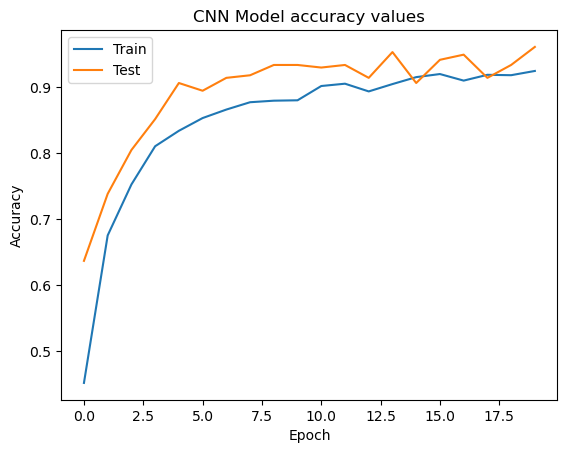

In [ ]:
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])
plt.title("CNN Model accuracy values")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()


In [ ]:
# loaded_model = load_model("/mnt/Storage/Dataset/Yolo-cls//model_HC2.h5")
loaded_model = load_model(model_dir)

# print(loaded_model.summary())
event_arcs = [21, 29, 30, 34, 48]
for i in event_arcs:
    img = image.load_img(
        "/mnt/Storage/Projects/E-YRC/EYRC_2023/Task_5/Task_5A/Event_" + str(i) + ".jpg",
        target_size=IMG_SIZE,
    )
    # img_array = transform(img)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    probabilities = loaded_model.predict(img_array)
    predicted_class_index = np.argmax(probabilities)
    pred = class_labels[predicted_class_index]
    print(pred)


1/1 [==============================] - 2s 2s/step
humanitarianaid
1/1 [==============================] - 0s 171ms/step
destroyedbuilding
1/1 [==============================] - 0s 142ms/step
combat
1/1 [==============================] - 0s 130ms/step
combat
1/1 [==============================] - 0s 210ms/step
combat


In [ ]:
# loaded_model = load_model("/mnt/Storage/Dataset/model_HC.h5")
loaded_model = load_model(model_dir)
# print(loaded_model.summary())
event_arcs = [21, 29, 30, 34, 48]
img = image.load_img(
    "/mnt/Storage/Downloads/Event_48.jpg",
    target_size=IMG_SIZE,
)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)   
img_array = preprocess_input(img_array)
probabilities = loaded_model.predict(img_array)
predicted_class_index = np.argmax(probabilities)
pred = class_labels[predicted_class_index]
print(pred)


1/1 [==============================] - 2s 2s/step
destroyedbuilding
